In [1]:
! pip install transformers torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.8 MB/s 
     |████████████████████████████████| 7.6 MB 16.4 MB/s 
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
     |████████████████████████████████| 7.6 MB 49.8 MB/s 
     |████████████████████████████████| 182 kB 71.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
tor

In [2]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.legacy import data
from torchtext.legacy import datasets

import transformers
from transformers import BertTokenizer, BertModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/MyDrive/ECE1786/Project")

In [5]:
! ls

Bert.ipynb     data_preprocessing.ipynb     Final_Project_v2.ipynb
Bert_v1.ipynb  data_preprocessing_v1.ipynb  model.drawio
data	       Final_Project_v1.ipynb	    models


# Tokenization

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

[CLS] [SEP] [PAD] [UNK]


In [7]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

In [8]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [9]:
TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

In [10]:
LABEL = data.LabelField(dtype = torch.float)

In [11]:
def get_dataset():
    train, valid, test = data.TabularDataset.splits(path='data/', 
                                                    train='train.tsv', 
                                                    validation='validation.tsv',
                                                    test = 'test.tsv',
                                                    format = 'tsv', 
                                                    skip_header = True,
                                                    fields = [(None, None), ('text', TEXT),('label', LABEL)])
    return train, valid, test

In [12]:
train_data, valid_data, test_data = get_dataset()

In [13]:
# Check the train dataset tokenization
print(vars(train_data[1000]))

{'text': [7868, 1996, 25283, 4890, 2253, 2041, 2023, 2851, 2031, 20446, 2050], 'label': '2'}


In [14]:
# Build vocabulary for labels
LABEL.build_vocab(train_data)

In [15]:
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1, '2': 2})


In [16]:
batch_size = 128

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# BucketIterator forms the batches in such a way that a minimum amount of padding is required
# 1. The train data is shuffled each epoch by default, and the validation/test data is sorted (which will return an error). We need to set sort = False so we dont sort test/validation data
# 2. For packed padded sequences all of the tensors within a batch need to be sorted by their lengths. This is handled in the iterator by setting sort_within_batch = True.

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: x.text, # sort key to minimize padding in training data
    sort = False, # dont sort test/validation data 
    batch_size=batch_size,
    device=device)

cuda


# Define the BERT model

In [17]:
class BERT(nn.Module):
    def __init__(self, bert, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text = [batch size, sent len]
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        # embedded = [batch size, sent len, emb dim]
        _, hidden = self.rnn(embedded)
        
        # hidden = [n layers * n directions, batch size, emb dim]
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        # hidden = [batch size, hid dim]
        output = self.out(hidden)
        
        # output = [batch size, out dim]
        return output

In [18]:
# Load the pre-trained model
bert = BertModel.from_pretrained('bert-base-uncased')

# Hyperparameters
GRU_OUTPUT_DIM = 512
MLP_OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = BERT(bert,
             GRU_OUTPUT_DIM,
             MLP_OUTPUT_DIM,
             N_LAYERS,
             BIDIRECTIONAL,
             DROPOUT)
print(model)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

In [19]:
# freeze paramers, we need to set their requires_grad attribute to False
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,666,115 trainable parameters


# Define the helper functions and parameters

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
criterion = torch.nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

def calculate_accuracy(preds, y):
    """
    returns accuracy per batch
    """
    class_preds = nn.Softmax(dim=-1)(preds)
    class_preds = class_preds.max(-1)[1]
    correct = (class_preds == y).float() # Convert into float for division
    acc = correct.sum() / len(correct)

    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in iterator:
        batch.text = batch.text.to(device)
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1).to(device)
        batch.label = batch.label.type(torch.LongTensor).to(device)

        loss = criterion(predictions, batch.label)
        acc = calculate_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    # Output tensor for predicted labels
    output = torch.LongTensor([]).to(device)
    model.eval()
  
    with torch.no_grad():
        for batch in iterator:
            batch.text = batch.text.to(device)
            predictions = model(batch.text).squeeze(1).to(device)
            batch.label = batch.label.type(torch.LongTensor).to(device)

            # assign label according to the largest value
            class_preds = nn.Softmax(dim=-1)(predictions)
            class_preds = class_preds.max(-1)[1]
            
            # combine all the values in batches
            output = torch.cat((output, class_preds), 0)
            loss = criterion(predictions, batch.label)
            
            acc = calculate_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), output

In [21]:
import time

# Helper function to print time between epochs
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Train the model

In [22]:
# Start training
N_EPOCHS = 50

best_valid_loss = float('inf')

train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, output = evaluate(model, valid_iterator, criterion) 
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/picked_model.pt')
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 1.093 | Train Acc: 36.55%
	 Val. Loss: 1.068 |  Val. Acc: 50.40%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 1.066 | Train Acc: 44.47%
	 Val. Loss: 1.036 |  Val. Acc: 57.10%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 1.031 | Train Acc: 51.28%
	 Val. Loss: 1.004 |  Val. Acc: 58.33%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.999 | Train Acc: 54.90%
	 Val. Loss: 0.961 |  Val. Acc: 58.21%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.952 | Train Acc: 57.32%
	 Val. Loss: 0.914 |  Val. Acc: 57.17%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.897 | Train Acc: 58.90%
	 Val. Loss: 0.848 |  Val. Acc: 62.82%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.838 | Train Acc: 63.22%
	 Val. Loss: 0.807 |  Val. Acc: 66.45%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.792 | Train Acc: 65.25%
	 Val. Loss: 0.796 |  Val. Acc: 64.40%
Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.751 | Train Acc: 68.50%
	 Val. Loss: 0.740 |  Val. Acc: 67.97%
Epoch: 10 | Epoch Time: 0m 8

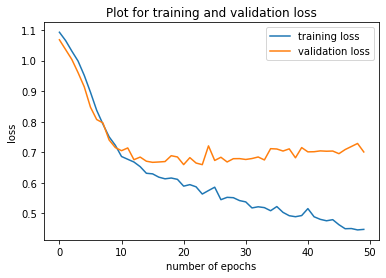

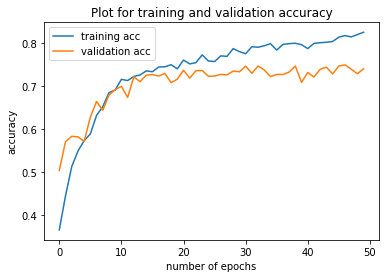

In [23]:
fig = plt.figure()
plt.plot(range(0, N_EPOCHS), train_loss_list, label ='training loss')
plt.plot(range(0, N_EPOCHS), valid_loss_list, label ='validation loss')
plt.title("Plot for training and validation loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(range(0, N_EPOCHS), train_acc_list, label ='training acc')
plt.plot(range(0, N_EPOCHS), valid_acc_list, label ='validation acc')
plt.title("Plot for training and validation accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Confirm the model we get on validation set
model.load_state_dict(torch.load('models/picked_model.pt'))

# Output tensor for predicted labels
total_output = torch.LongTensor([]).to(device)
total_preds = torch.LongTensor([]).to(device)
model.eval()
with torch.no_grad():
    for batch in valid_iterator:
        batch.text = batch.text.to(device)
        predictions = model(batch.text).squeeze(1).to(device)
        batch.label = batch.label.type(torch.LongTensor).to(device)

        # assign label according to the largest value
        class_preds = nn.Softmax(dim=-1)(predictions)
        class_preds = class_preds.max(-1)[1]

        total_output = torch.cat((total_output, batch.label), 0)
        total_preds = torch.cat((total_preds, class_preds), 0)


print(classification_report(total_output.cpu(), total_preds.cpu()))

              precision    recall  f1-score   support

           0       0.72      0.66      0.68       229
           1       0.76      0.70      0.73       229
           2       0.72      0.84      0.77       229

    accuracy                           0.73       687
   macro avg       0.73      0.73      0.73       687
weighted avg       0.73      0.73      0.73       687

